In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols



I have recently purchased new golf clubs, which I believe will significantly improve my game. Below are the scores of three rounds of golf played at three different golf courses with the old and the new clubs.

### Q1: Conduct an analysis of variance. Using 𝛼 = 0.05, what conclusions can you draw?

In [2]:
# Data

data = {
    "Clubs": ["Old", "Old", "Old", "New", "New", "New"],
    "Ahwatukee": [90, 87, 86, 88, 87, 85],
    "Karsten": [91, 93, 90, 90, 91, 88],
    "Foothills": [88, 86, 90, 86, 85, 88]
}

df = pd.DataFrame(data)
df

,Clubs,Ahwatukee,Karsten,Foothills
0,Old,90,91,88
1,Old,87,93,86
2,Old,86,90,90
3,New,88,90,86
4,New,87,91,85
5,New,85,88,88


In [6]:
# Convert to long (tidy) format for ANOVA
df_long = df.melt(id_vars="Clubs", var_name="Course", value_name="Score")

In [7]:
# --- Two-way ANOVA with interaction ---
model = ols("Score ~ C(Clubs) * C(Course)", data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Wide data:")
print(df, "\n")
print("Long data:")
print(df_long, "\n")
print("Two-way ANOVA (typ=2):")
print(anova_table)

Wide data:
  Clubs  Ahwatukee  Karsten  Foothills
0   Old         90       91         88
1   Old         87       93         86
2   Old         86       90         90
3   New         88       90         86
4   New         87       91         85
5   New         85       88         88 

Long data:
   Clubs     Course  Score
0    Old  Ahwatukee     90
1    Old  Ahwatukee     87
2    Old  Ahwatukee     86
3    New  Ahwatukee     88
4    New  Ahwatukee     87
5    New  Ahwatukee     85
6    Old    Karsten     91
7    Old    Karsten     93
8    Old    Karsten     90
9    New    Karsten     90
10   New    Karsten     91
11   New    Karsten     88
12   Old  Foothills     88
13   Old  Foothills     86
14   Old  Foothills     90
15   New  Foothills     86
16   New  Foothills     85
17   New  Foothills     88 

Two-way ANOVA (typ=2):
                       sum_sq    df         F    PR(>F)
C(Clubs)             9.388889   1.0  3.188679  0.099424
C(Course)           44.444444   2.0  7.547170  0.0075

### Q2: Do you have any recommendations or suggestions for me?

Answer: Only course is significant. 

Since there is no interaction, so:

New clubs are not better on one course and worse on another.
Old vs New behaves the same across all courses.

So you cannot make recommendations like:

“Use old clubs only at Foothills”

“Use new clubs only at Karsten”

Those would require a significant interaction, which we do not have.

In [22]:
df_long[["Course", "Score"]].groupby(["Course"]).mean().reset_index()

,Course,Score
0,Ahwatukee,87.166667
1,Foothills,87.166667
2,Karsten,90.500000


In [29]:
df_long[["Course", "Clubs", "Score"]].groupby(["Course", "Clubs"]).mean().reset_index()

,Course,Clubs,Score
0,Ahwatukee,New,86.666667
1,Ahwatukee,Old,87.666667
2,Foothills,New,86.333333
3,Foothills,Old,88.000000
4,Karsten,New,89.666667
5,Karsten,Old,91.333333


### 1. Residuals vs. Fitted values

This checks if residuals are randomly scattered (no pattern = good).

Check: constant variance assumption and independence assumption

In [25]:
# Residuals
fitted = model.fittedvalues
residuals = model.resid

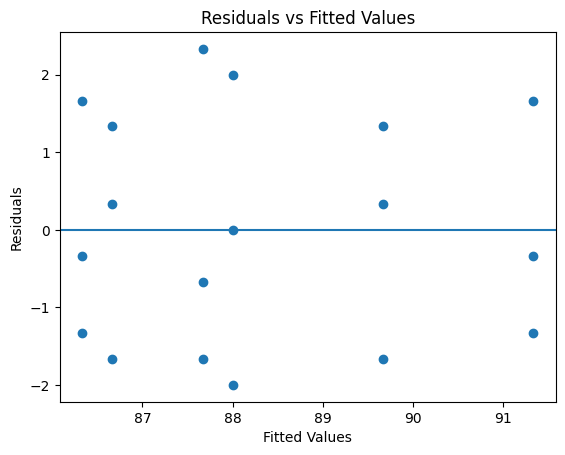

In [26]:

# Plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


### 2. QQ Plot of residuals: Check normality of residuals assumption

<Figure size 640x480 with 0 Axes>

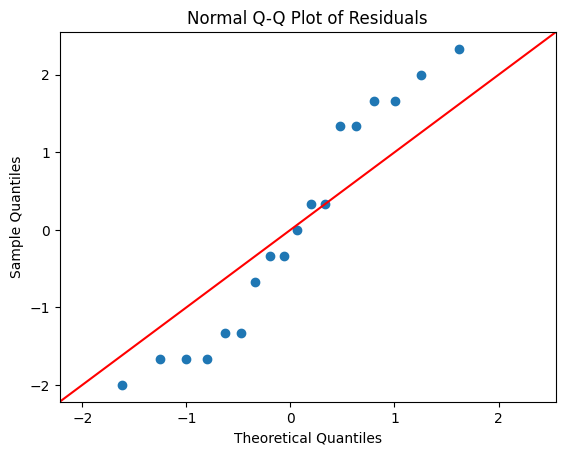

In [27]:
# Q-Q plot
plt.figure()
sm.qqplot(residuals, line="45")
plt.title("Normal Q-Q Plot of Residuals")
plt.show()


A textile company weaves a fabric on a large number of looms. It would like the looms to be homogeneous so that it obtains a fabric of uniform strength. The process engineer suspects that, in addition to the usual variation in strength within samples of fabric from the same loom, there may also be significant variations in strength between looms. To investigate this, she selects four looms at random and makes four strength determinations on the fabric manufactured on each loom. This experiment is run in random order, and the data obtained are shown in Table 3.18.

In [11]:
df = pd.DataFrame({
    "Loom":     [1,1,1,1,   2,2,2,2,   3,3,3,3,   4,4,4,4],
    "Obs":      [1,2,3,4]*4,
    "Strength": [98,97,99,96,   91,90,93,92,   96,95,97,95,   95,96,99,98]
})

In [12]:
df.head()

,Loom,Obs,Strength
0,1,1,98
1,1,2,97
2,1,3,99
3,1,4,96
4,2,1,91


In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import chi2, f

In [14]:
def lrt_random_intercept(formula, data, group_col):
    """
    Likelihood ratio test for a single random intercept.
    H0: variance(component) = 0  (no random intercept)
    H1: variance(component) > 0  (random intercept present)

    Returns: dict with ll_full, ll_null, lrt, p_value
    """
    # FULL model: random intercept by group (fit with ML)
    m_full = mixedlm(formula, data=data, groups=data[group_col])
    fit_full = m_full.fit(reml=True)
    print("Random effect summary:")
    print(fit_full.summary())
    
    # Variance components and ICC
    between_var = float(fit_full.cov_re.iloc[0, 0])   # sigma_alpha^2 (between-loom variance)
    resid_var   = float(fit_full.scale)               # sigma^2 (within-loom/residual variance)
    icc = between_var / (between_var + resid_var)

    print("\nEstimated variance components:")
    print(f"  Between-loom variance (sigma_alpha^2): {between_var:.3f}")
    print(f"  Residual variance (sigma^2):           {resid_var:.3f}")
    print(f"  Intraclass correlation (ICC):          {icc:.3f}")
    print(f"  {100*icc:.1f}% of total variance comes from the treatment(loom).")

    # NULL model: intercept-only Gaussian model (no random effect), also ML
    fit_null = sm.OLS.from_formula(formula, data=data).fit()

    # Likelihood ratio
    lrt = 2 * (fit_full.llf - fit_null.llf)

    # Boundary-corrected p-value (0.5 * chi^2_1 upper tail)
    p_val = 0.5 * (1 - chi2.cdf(lrt, df=1))

    return {
        "ll_full": fit_full.llf,
        "ll_null": fit_null.llf,
        "lrt": lrt,
        "p_value": p_val,
        "fit_full": fit_full,  # return the fitted model too, handy to inspect
    }


res = lrt_random_intercept("Strength ~ 1", data=df, group_col="Loom")

Random effect summary:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Strength
No. Observations: 16      Method:             REML    
No. Groups:       4       Scale:              1.8958  
Min. group size:  4       Log-Likelihood:     -31.5965
Max. group size:  4       Converged:          Yes     
Mean group size:  4.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   95.437    1.363 70.015 0.000 92.766 98.109
Group Var    6.958    4.927                           


Estimated variance components:
  Between-loom variance (sigma_alpha^2): 6.958
  Residual variance (sigma^2):           1.896
  Intraclass correlation (ICC):          0.786
  78.6% of total variance comes from the treatment(loom).


In [15]:
print("LL(full):", res["ll_full"])
print("LL(null):", res["ll_null"])
print("LRT:", res["lrt"])
print("p-value (boundary-corrected):", res["p_value"])

LL(full): -31.596516242736673
LL(null): -38.265832191923955
LRT: 13.338631898374565
p-value (boundary-corrected): 0.00012999698049870334


In [16]:
# If you also want the classical ANOVA F-test (balanced one-way designs):

loom_groups = df.groupby("Loom")["Strength"].apply(list)
f_statistic, p_value = stats.f_oneway(*loom_groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 15.681318681318682
P-value: 0.00018779198099318047


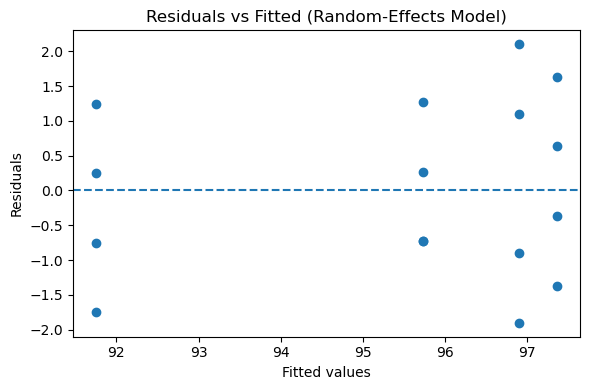

In [17]:
# 4) Simple diagnostic: residuals vs fitted
# -----------------------------
df["Fitted"] = res["fit_full"].fittedvalues
df["Residual"] = df["Strength"] - df["Fitted"]

plt.figure(figsize=(6,4))
plt.scatter(df["Fitted"], df["Residual"])
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Random-Effects Model)")
plt.tight_layout()
plt.show()